In [1]:
import requests_cache
requests_cache.install_cache('cache', allowable_codes=[200, 404], allowable_methods=['GET', 'POST'])
import requests
import pandas as pd
from tqdm.auto import tqdm
import json
pd.set_option("display.max_columns", None)

price_history = pd.read_csv("price_history.csv")
price_history.sort_values(price_history.columns.tolist(), inplace=True)

all_products = []
new_prices = []
for page in tqdm(range(1, 84)):
    try:
        r = requests.get("https://www.woolworths.co.nz/api/v1/products", params={
            "target": "browse",
            "inStockProductsOnly": "false",
            "size": 120,
            "page": page
        }, headers={
            "x-requested-with": "??",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36 Edg/129.0.0.0"
        }, timeout=5)
        r.raise_for_status()
        timestamp = int(r.created_at.timestamp())
        products = r.json()["products"]["items"]
        assert len(products) > 0, "No products"
        for product in products:
            sku = int(product["sku"])
            prices = price_history[price_history.SKU == sku].price
            if len(prices) == 0:
                last_price = None
            else:
                last_price = prices.iloc[-1]
            if product["price"]["salePrice"] != last_price:
                print(f"SKU {sku} price changed from {last_price} to {product['price']['salePrice']}")
                new_prices.append({
                    "SKU": sku,
                    "timestamp": timestamp,
                    "price": product["price"]["salePrice"]
                })
        all_products.extend(products)
    except Exception as e:
        raise
df = pd.json_normalize(all_products)
df.to_csv("products.csv", index=False)
df

  0%|          | 0/83 [00:00<?, ?it/s]

SKU 267174 price changed from 2.0 to 3.2
SKU 267425 price changed from 2.5 to 3.9
SKU 267392 price changed from 2.0 to 3.2
SKU 687630 price changed from 2.5 to 3.9
SKU 267204 price changed from 7.0 to 8.5
SKU 366221 price changed from 6.99 to 7.99
SKU 513705 price changed from 8.9 to 9.9
SKU 567609 price changed from None to 6.99
SKU 729772 price changed from None to 10.0
SKU 803143 price changed from None to 8.45
SKU 350322 price changed from None to 2.99
SKU 257596 price changed from None to 13.9
SKU 53363 price changed from 11.0 to 9.5
SKU 33378 price changed from 21.99 to 20.0
SKU 19437 price changed from None to 5.0


,type,name,barcode,variety,brand,slug,sku,unit,selectedPurchasingUnit,stockLevel,eachUnitQuantity,averageWeightPerUnit,hasShopperNotes,productTag,departments,subsAllowed,supportsBothEachAndKgPricing,adId,brandSuggestionId,brandSuggestionName,priceUnitLabel,availabilityStatus,onlineSample,onlineSampleRealProductMapId,price.originalPrice,price.salePrice,price.savePrice,price.savePercentage,price.canShowSavings,price.hasBonusPoints,price.isClubPrice,price.isSpecial,price.isNew,price.canShowOriginalPrice,price.discount,price.total,price.isTargetedOffer,price.averagePricePerSingleUnit,price.isBoostOffer,price.purchasingUnitPrice,price.orderedPrice,price.isUsingOrderedPrice,price.currentPricingMatchesOrderedPricing,price.extendedListPrice,price.originalAveragePricePerSingleUnit,images.small,images.big,quantity.min,quantity.max,quantity.increment,quantity.value,quantity.quantityInOrder,quantity.purchasingQuantityString,size.cupListPrice,size.cupPrice,size.cupMeasure,size.packageType,size.volumeSize,productTag.tagType,productTag.multiBuy,productTag.bonusPoints,productTag.additionalTag.name,productTag.additionalTag.link,productTag.additionalTag.imagePath,productTag.additionalTag.linkTarget,productTag.additionalTag.altText,productTag.targetedOffer,productTag.boostOffer,productTag.multiBuy.quantity,productTag.multiBuy.value,productTag.multiBuy.link,productTag.multiBuy.multiCupValue,productTag.additionalTag
0,Product,fresh fruit bananas yellow,9354829000064,yellow,fresh fruit,fresh-fruit-bananas-yellow,133211,Kg,None,3,None,0.25,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,In Stock,None,0,3.45,3.45,0.0,0.0,True,False,False,False,False,True,None,None,False,0.86,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.2,100.0,0.2,None,None,None,3.450000,3.45,1kg,loose,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Product,fresh vegetable cucumbers telegraph,9421901390013,telegraph,fresh vegetable,fresh-vegetable-cucumbers-telegraph,281455,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,False,None,None,None,None,In Stock,None,0,2.50,2.50,0.0,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,3.190000,2.50,1ea,,,Other,NaN,NaN,Fresh Deals,,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Product,woolworths butter salted,9300633725082,salted,woolworths,woolworths-butter-salted,827847,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,6.49,6.49,0.0,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/8...,https://assets.woolworths.com.au/images/2010/8...,1.0,4.0,1.0,None,None,None,1.300000,1.30,100g,None,500g,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Product,fresh fruit strawberries,9342373000258,None,fresh fruit,fresh-fruit-strawberries,144607,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,False,None,None,None,None,In Stock,None,0,5.50,5.50,0.0,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,1.0,100.0,1.0,None,None,None,58.778255,35.96,1kg,punnet,250g,Other,NaN,NaN,Fresh Deals,,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Product,woolworths milk standard,9414742036509,standard,woolworths,woolworths-milk-standard,282768,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In 

In [2]:
price_history = pd.concat([price_history, pd.DataFrame(new_prices)], ignore_index=True).sort_values(price_history.columns.tolist())
price_history

,SKU,timestamp,price
0,25,1728880327,3.99
1,168,1728880353,2.60
2,326,1728880348,4.30
3,579,1728880353,1.00
4,579,1729443688,2.00
...,...,...,...
61041,991433,1731863075,12.00
61042,991433,1734282073,10.80
61043,997826,1728880366,7.00
61044,6000520,1733763840,11.00


In [3]:
price_history.groupby("SKU").size().value_counts()

1     2870
10    1651
9     1033
8      839
6      810
2      807
7      754
5      641
3      630
11     456
4      361
12     156
13      32
16       3
15       1
14       1
dtype: int64

In [4]:
delta = price_history.groupby("SKU").price.diff()
delta.describe()

count    50016.000000
mean        -0.008315
std          2.505764
min        -28.990000
25%         -1.090000
50%         -0.010000
75%          1.090000
max         28.990000
Name: price, dtype: float64

<Axes: ylabel='Frequency'>

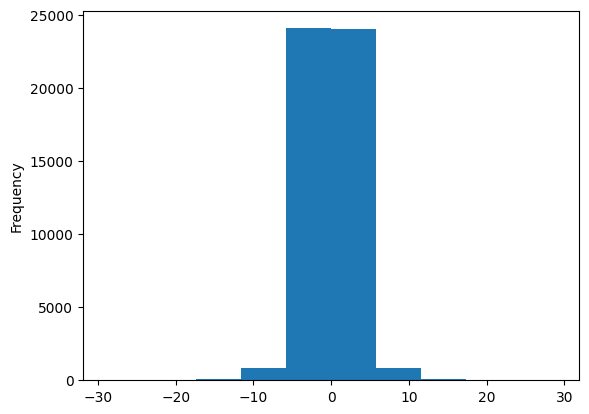

In [5]:
delta.plot.hist()

In [6]:
price_history.to_csv("price_history.csv", index=False)